In [63]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [64]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrAandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_C'

#file name
fname='F0594_FO_IMA_07018937_FORF253_CAL_0018-0047_Field_X.fits'

#Name of field
field='FieldX'

#wavelength of data
wavelength=25.2

In [65]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

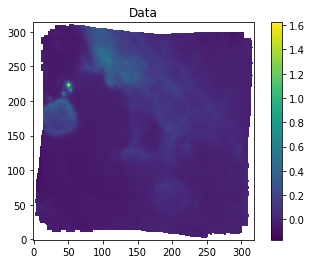

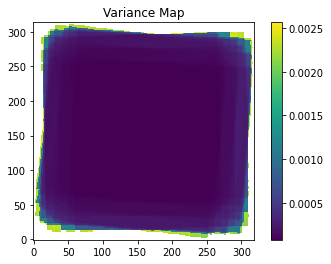

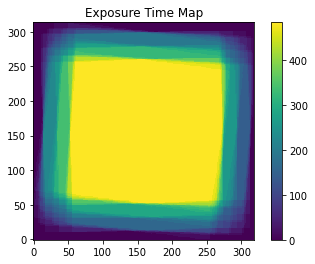

In [66]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

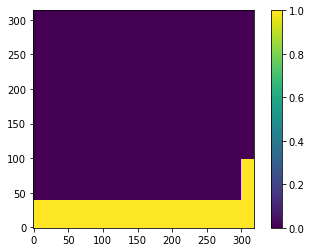

In [67]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.2,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
mask2[0:40,0:340]=1
mask2[0:100,300:340]=1

mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [68]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

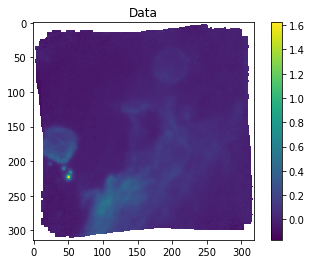

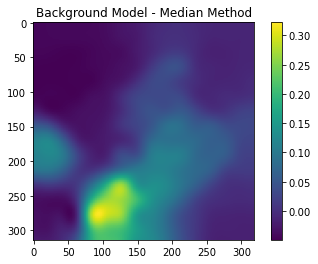

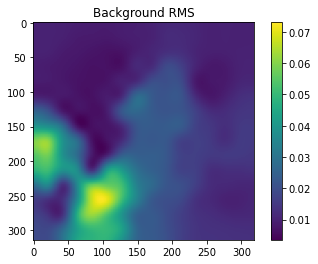

In [69]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [70]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

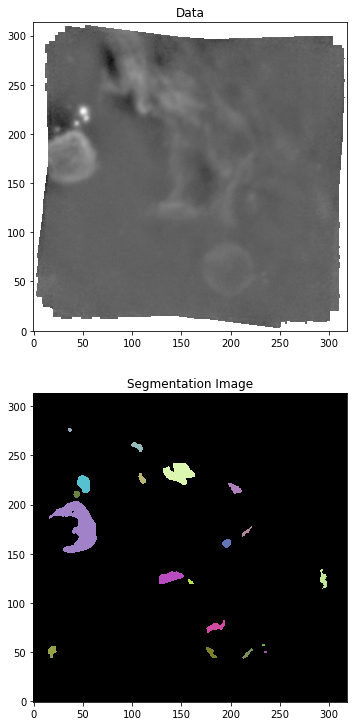

In [71]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [72]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,217.02530182191475,48.72092312088957,"266.51913456874007,-28.861889417590522",0.04155296190891281,0.01755265577233066,0.6670009193485651,38.0,3.642353914751315,0.8548424739901938,45.460187714588514,0.7322966863797892,-1.2929031905216481,0.7115262439298239,0.9720690450631767,0.76530493905929,4.2608480808747204,6.229711409890033,8.646837341864266,nan,3.1065334994665443,1.7986505480939476,nan
3,18.548204793719325,51.30891509909569,"266.56748158462176,-28.861334877113645",-0.040833184525067616,-0.046200829117428795,-3.187857209102587,69.0,2.941852697758363,1.8931203095875266,71.10922853053546,0.26188886223880303,-0.1001554663184103,0.1326832908190753,0.7654352242272028,0.3564870494603455,1.5539702801029769,5.825122729534038,13.78084210273877,nan,3.299827713817462,2.7993186376223473,nan
4,180.66192308855875,50.0640606067945,"266.5279923741661,-28.86160372581618",0.06513554440470819,0.009047730126795547,0.5338160774809373,59.0,3.6594458792748656,1.3656495642204411,-51.331244640518015,0.35601794582536295,0.45029445376964355,0.254849435648378,0.9277570306795029,0.6268152039206958,2.679637569659974,6.503854143294474,12.485080703698824,nan,3.1387250287436776,2.70759215511856,nan
5,235.99740962732307,50.51007561587722,"266.5145132199956,-28.861507061599468",0.000793863232686825,-0.0048875999499740546,-0.02932559969984433,6.0,0.7634514649856499,0.49974593465010403,1.225944813407133,1.7167308539829156,-0.09789821608557091,4.003020633222575,0.7559860776867177,0.34541230507757625,1.5276791906675111,1.5193646187598848,1.2804290124435287,nan,3.446807225260684,0.23257580484413048,nan
7,233.89648092273853,57.525861363283056,"266.5150252934631,-28.860010443020542",0.00707631427127051,-0.0012616081170720066,-0.00756964870243204,6.0,0.7813940302909692,0.4988187760134501,2.153947599476065,1.6411597112246783,-0.17886434151498615,4.015603118265203,0.7697293704560951,0.3616296558757891,1.5664888088933921,1.543617141915591,1.0228566126027585,nan,3.2289759999871133,0.262010673438002,nan
9,185.52022207947107,75.70959937006455,"266.5268094492976,-28.856132599280755",-0.006247719325072124,0.03459091013993509,3.8395910255327945,111.0,5.428906575630725,1.9375012789507056,17.476551592429363,0.05489470592080114,-0.13317738646995603,0.24542344877479141,0.9341479078509507,0.6431139029638563,2.802014447479933,9.598157794832513,27.739277677548166,nan,2.9301728053120413,6.969461262999465,nan
11,294.98491688882376,124.1808603077534,"266.50014995348346,-28.84578754191458",0.21989404866778448,0.014457614369887576,1.1710667639608936,81.0,4.723927924264448,1.5518375234356716,-79.43244767337406,0.4027888558211432,0.13356751404338202,0.05727101106813346,0.9445019676895833,0.6714942420131643,3.0440866733303147,8.27941043723695,14.438653320796828,nan,2.8676142613579505,4.10817098695678,nan
12,138.96548054560188,126.3464320910526,"266.5381489525974,-28.845330410443903",0.0038081547848573113,0.015416328350398566,3.160347311831706,205.0,6.485421911101021,2.397298796537795,12.817219717099468,0.031168407679569347,-0.0649925441784605,0.16660932783012675,0.9291733650496139,0.6303557687689729,2.705303953127302,11.513088103023314,45.44029038356638,nan,2.268900941750558,20.405999378227,nan


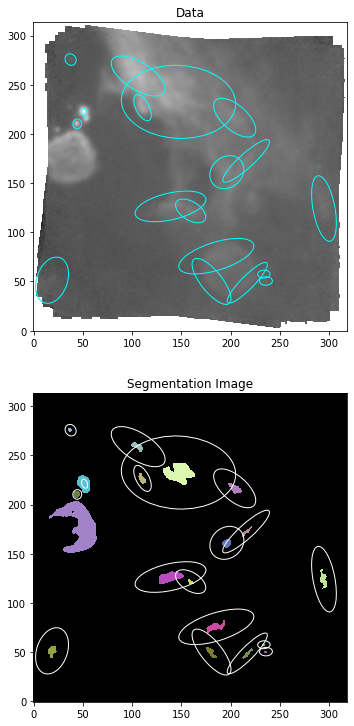

In [73]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

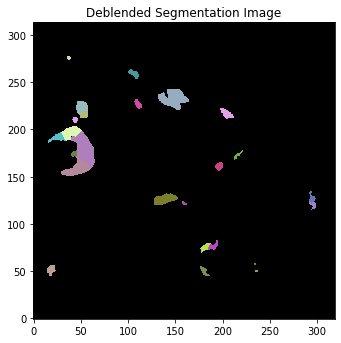

In [74]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [75]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,217.02530182191475,48.72092312088957,"266.51913456874007,-28.861889417590522",0.04155296190891281,0.01755265577233066,0.6670009193485651,38.0,3.642353914751315,0.8548424739901938,45.460187714588514,0.7322966863797892,-1.2929031905216481,0.7115262439298239,0.9720690450631767,0.76530493905929,4.2608480808747204,6.229711409890033,8.646837341864266,nan,3.1065334994665443,1.7986505480939476,nan
2,18.548204793719325,51.30891509909569,"266.56748158462176,-28.861334877113645",-0.040833184525067616,-0.046200829117428795,-3.187857209102587,69.0,2.941852697758363,1.8931203095875266,71.10922853053546,0.26188886223880303,-0.1001554663184103,0.1326832908190753,0.7654352242272028,0.3564870494603455,1.5539702801029769,5.825122729534038,13.78084210273877,nan,3.299827713817462,2.7993186376223473,nan
3,180.66192308855875,50.0640606067945,"266.5279923741661,-28.86160372581618",0.06513554440470819,0.009047730126795547,0.5338160774809373,59.0,3.6594458792748656,1.3656495642204411,-51.331244640518015,0.35601794582536295,0.45029445376964355,0.254849435648378,0.9277570306795029,0.6268152039206958,2.679637569659974,6.503854143294474,12.485080703698824,nan,3.1387250287436776,2.70759215511856,nan
4,235.99740962732307,50.51007561587722,"266.5145132199956,-28.861507061599468",0.000793863232686825,-0.0048875999499740546,-0.02932559969984433,6.0,0.7634514649856499,0.49974593465010403,1.225944813407133,1.7167308539829156,-0.09789821608557091,4.003020633222575,0.7559860776867177,0.34541230507757625,1.5276791906675111,1.5193646187598848,1.2804290124435287,nan,3.446807225260684,0.23257580484413048,nan
5,233.89648092273853,57.525861363283056,"266.5150252934631,-28.860010443020542",0.00707631427127051,-0.0012616081170720066,-0.00756964870243204,6.0,0.7813940302909692,0.4988187760134501,2.153947599476065,1.6411597112246783,-0.17886434151498615,4.015603118265203,0.7697293704560951,0.3616296558757891,1.5664888088933921,1.543617141915591,1.0228566126027585,nan,3.2289759999871133,0.262010673438002,nan
6,138.96548054560188,126.3464320910526,"266.5381489525974,-28.845330410443903",0.0038081547848573113,0.015416328350398566,3.160347311831706,205.0,6.485421911101021,2.397298796537795,12.817219717099468,0.031168407679569347,-0.0649925441784605,0.16660932783012675,0.9291733650496139,0.6303557687689729,2.705303953127302,11.513088103023314,45.44029038356638,nan,2.268900941750558,20.405999378227,nan
7,159.44806230352773,121.70106730897217,"266.5331603476377,-28.84632139119983",-0.009170995080195265,0.039008537576164855,0.9362049018279566,24.0,1.8903288480953946,1.0258609343763332,-32.1040503923835,0.46919400418857093,0.6035856936989614,0.7608734550903531,0.8399336275976748,0.4573108613297936,1.842675536957268,3.581236852738371,19.622963820860477,nan,3.632388654909018,2.124466606484269,nan
8,196.28547491518063,161.09656224324695,"266.5241894302334,-28.837916502695677",0.08425011060986336,0.08986407346769457,5.481708481529369,61.0,2.323171982677193,1.948908303889549,39.63441977871176,0.2170202037773337,-0.07663184347155808,0.23154310973355136,0.5442860236980761,0.16110028942254517,1.1920376028162558,5.049255757089861,21.9317741488613,nan,3.1800094504468612,5.190361604472981,nan


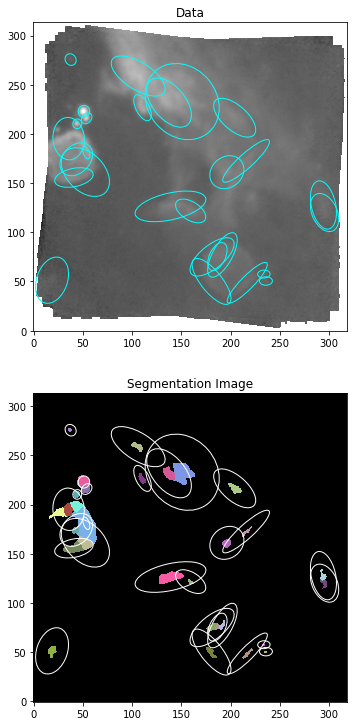

In [76]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [77]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [78]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [79]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,217.02530182191475,48.72092312088957,"266.51913456874007,-28.861889417590522",0.04155296190891281,0.01755265577233066,0.6670009193485651,38.0,3.642353914751315,0.8548424739901938,45.460187714588514,0.7322966863797892,-1.2929031905216481,0.7115262439298239,0.9720690450631767,0.76530493905929,4.2608480808747204,6.229711409890033,8.646837341864266,0.2682383314775441,3.1065334994665443,1.7986505480939476,0.06855145,0.018207347103922758,0.017743991450501168,0.005247126986208213,2.0869117599633915
2,18.548204793719325,51.30891509909569,"266.56748158462176,-28.861334877113645",-0.040833184525067616,-0.046200829117428795,-3.187857209102587,69.0,2.941852697758363,1.8931203095875266,71.10922853053546,0.26188886223880303,-0.1001554663184103,0.1326832908190753,0.7654352242272028,0.3564870494603455,1.5539702801029769,5.825122729534038,13.78084210273877,0.8488259584475649,3.299827713817462,2.7993186376223473,0.151624,-0.04607519100413678,-0.04608795671480715,0.0007047347061075492,7.188998107537028
3,180.66192308855875,50.0640606067945,"266.5279923741661,-28.86160372581618",0.06513554440470819,0.009047730126795547,0.5338160774809373,59.0,3.6594458792748656,1.3656495642204411,-51.331244640518015,0.35601794582536295,0.45029445376964355,0.254849435648378,0.9277570306795029,0.6268152039206958,2.679637569659974,6.503854143294474,12.485080703698824,0.34392924397352787,3.1387250287436776,2.70759215511856,0.086375915,0.009678510051271079,0.009387778463993076,0.005182841406905652,3.383816553941544
4,235.99740962732307,50.51007561587722,"266.5145132199956,-28.861507061599468",0.000793863232686825,-0.0048875999499740546,-0.02932559969984433,6.0,0.7634514649856499,0.49974593465010403,1.225944813407133,1.7167308539829156,-0.09789821608557091,4.003020633222575,0.7559860776867177,0.34541230507757625,1.5276791906675111,1.5193646187598848,1.2804290124435287,0.09922388820586614,3.446807225260684,0.23257580484413048,0.025995832,-0.0048875999499740546,-0.004912494433683204,0.0007878569604581903,1.4424895387632697
5,233.89648092273853,57.525861363283056,"266.5150252934631,-28.860010443020542",0.00707631427127051,-0.0012616081170720066,-0.00756964870243204,6.0,0.7813940302909692,0.4988187760134501,2.153947599476065,1.6411597112246783,-0.17886434151498615,4.015603118265203,0.7697293704560951,0.3616296558757891,1.5664888088933921,1.543617141915591,1.0228566126027585,0.08303437702290321,3.2289759999871133,0.262010673438002,0.022766104,-0.0012616081170720066,-0.0013003324094431035,0.0010887134624775377,1.7364993535000066
6,138.96548054560188,126.3464320910526,"266.5381489525974,-28.845330410443903",0.0038081547848573113,0.015416328350398566,3.160347311831706,205.0,6.485421911101021,2.397298796537795,12.817219717099468,0.031168407679569347,-0.0649925441784605,0.16660932783012675,0.9291733650496139,0.6303557687689729,2.705303953127302,11.513088103023314,45.44029038356638,0.3524341118691018,2.268900941750558,20.405999378227,0.12710862,0.017505073243680523,0.01790868257527332,0.009921339192542294,10.470277090689848
7,159.44806230352773,121.70106730897217,"266.5331603476377,-28.84632139119983",-0.009170995080195265,0.039008537576164855,0.9362049018279566,24.0,1.8903288480953946,1.0258609343763332,-32.1040503923835,0.46919400418857093,0.6035856936989614,0.7608734550903531,0.8399336275976748,0.4573108613297936,1.842675536957268,3.581236852738371,19.622963820860477,0.198252091850

In [80]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [81]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,217.02530182200553,48.72092312092677,"266.51913456874007,-28.861889417590522",0.9636205046536871,0.05156248907069991,3.016754670980624,0.1027839970416778,5.117058029011923,0.15250941781130337,7.031423816235168,0.20129393170772608,8.695725292802813,0.24999325420700633
2,18.548204793798945,51.308915099070575,"266.56748158462176,-28.861334877113645",0.9745237924471304,0.08392997388909511,3.1208234705813545,0.17001274378331396,5.367631147680341,0.25833654150652946,7.708158735962943,0.36823754962838373,10.206793805116297,0.5233264714232634
3,180.66192308865652,50.06406060686385,"266.5279923741661,-28.86160372581618",0.9992482176269465,0.05263724281830132,3.3622847380109353,0.10419496313088095,5.942302683486979,0.15296138820710112,8.301905400392368,0.20101486461388418,10.23137058969888,0.2488779425318437
4,235.9974096274247,50.51007561590771,"266.5145132199956,-28.861507061599468",0.6244021667684663,0.04893905912117661,1.330650459481503,0.09702574591496063,2.0599972977703986,0.14522361591939054,2.4587056315455147,0.1932364655403045,2.6418115397967603,0.24115284610213766
5,233.89648092274336,57.52586136329262,"266.5150252934631,-28.860010443020542",0.6432434119719237,0.042903074401042594,1.0911370674214385,0.08599721902298994,1.6666778472055181,0.1306228870228446,2.6778627861139683,0.17649915492585136,3.734867343684162,0.22306120591984527
6,138.96548054555737,126.34643209110575,"266.5381489525974,-28.845330410443903",2.5564579390898476,0.040829030900852346,9.057891724071624,0.08175820132542964,17.610544067000117,0.12276524595494204,26.724615443275503,0.163807692469944,34.69879065323872,0.20484800870846848
7,159.44806230352125,121.7010673090428,"266.5331603476377,-28.84632139119983",1.8500454402372113,0.04081502588545938,6.216503981557254,0.08163274415216673,11.147378592636269,0.12243318260108584,15.613460950794407,0.16323431609544403,19.492978122250257,0.20406333541803212
8,196.28547491512018,161.09656224323243,"266.5241894302334,-28.837916502695677",2.0634773805885818,0.04099898241717754,6.646745070671245,0.08191100241136882,11.159605059975092,0.12281295241749046,15.33065490811052,0.16368128429673862,19.508123667326245,0.2045930546473037


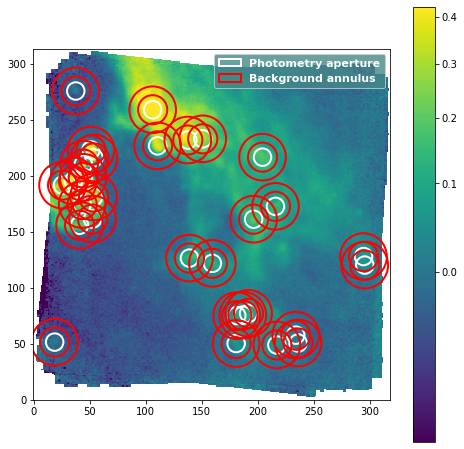

In [82]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [83]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [84]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-84-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,217.02530182200553,48.72092312092677,"266.51913456874007,-28.861889417590522",5.117058029011923,0.15250941781130337,0.001994117191944061,0.0041313547225150385,4.734690852976839,0.15250941781130337,0.001994117191944061,5.835479066265427
2,18.548204793798945,51.308915099070575,"266.56748158462176,-28.861334877113645",5.367631147680341,0.25833654150652946,1.4617723687297816e-07,0.0029083405247962973,5.367603118546703,0.25833654150652946,1.4617723687297818e-07,9.518655343056396
3,180.66192308865652,50.06406060686385,"266.5279923741661,-28.86160372581618",5.942302683486979,0.15296138820710112,0.001779130136158599,0.005130616128290003,5.601158758390644,0.15296138820710112,0.0017791301361585992,7.182568974321732
4,235.9974096274247,50.51007561590771,"266.5145132199956,-28.861507061599468",2.0599972977703986,0.14522361591939054,-0.0011546465388466284,-0.00048118012512096865,2.2813979948613516,0.14522361591939054,0.0,5.396275542126875
5,233.89648092274336,57.52586136329262,"266.5150252934631,-28.860010443020542",1.6666778472055181,0.1306228870228446,-0.0009010100425519687,0.0005221046849193452,1.8394443560855593,0.1306228870228446,0.0,4.587633342237268
6,138.96548054555737,126.34643209110575,"266.5381489525974,-28.845330410443903",17.610544067000117,0.12276524595494204,0.009664135547662184,0.014291732209885739,15.75746931637457,0.12276524595494204,0.009664135547662184,10.104673114506653
7,159.44806230352125,121.7010673090428,"266.5331603476377,-28.84632139119983",11.147378592636269,0.12243318260108584,-3.856134275375058e-05,0.001914457127421355,11.154772637375684,0.12243318260108584,0.0,28.735769941149663
8,196.28547491512018,161.09656224323243,"266.5241894302334,-28.837916502695677",11.159605059975092,0.12281295241749046,0.009027634644080948,0.004243496225660899,9.428577826932436,0.12281295241749046,0.009027634644080948,6.241970747328412


In [85]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [86]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,217.02530182191475,48.72092312088957,"266.51913456874007,-28.861889417590522",0.04155296190891281,0.01755265577233066,0.6670009193485651,38.0,3.642353914751315,0.8548424739901938,45.460187714588514,0.7322966863797892,-1.2929031905216481,0.7115262439298239,0.9720690450631767,0.76530493905929,4.2608480808747204,6.229711409890033,8.646837341864266,0.2682383314775441,3.1065334994665443,1.7986505480939476,0.06855145,0.018207347103922758,0.017743991450501168,0.005247126986208213,2.0869117599633915,0.9636205046536871,0.05156248907069991,3.016754670980624,0.1027839970416778,5.117058029011923,0.15250941781130337,7.031423816235168,0.20129393170772608,8.695725292802813,0.24999325420700633,0.001994117191944061,0.0041313547225150385,4.734690852976839,0.15250941781130337,0.001994117191944061,5.835479066265427,0.9211352628720111,2.84681370385392,6.351659947728352,7.633594248260914,2.965866204642761,5.19152173739494,5.698177814859696,5.202162324149334,5.835479066265427,C7FieldX,25.2
2,18.548204793719325,51.30891509909569,"266.56748158462176,-28.861334877113645",-0.040833184525067616,-0.046200829117428795,-3.187857209102587,69.0,2.941852697758363,1.8931203095875266,71.10922853053546,0.26188886223880303,-0.1001554663184103,0.1326832908190753,0.7654352242272028,0.3564870494603455,1.5539702801029769,5.825122729534038,13.78084210273877,0.8488259584475649,3.299827713817462,2.7993186376223473,0.151624,-0.04607519100413678,-0.04608795671480715,0.0007047347061075492,7.188998107537028,0.9745237924471304,0.08392997388909511,3.1208234705813545,0.17001274378331396,5.367631147680341,0.25833654150652946,7.708158735962943,0.36823754962838373,10.206793805116297,0.5233264714232634,1.4617723687297816e-07,0.0029083405247962973,5.367603118546703,0.25833654150652946,1.4617723687297818e-07,9.518655343056396,0.9745206780989484,3.1208110131886264,7.70810890639203,10.206715946411745,3.3214427042847334,7.207902393043793,10.69560566743421,11.013102706242728,11.013102706242728,C7FieldX,25.2
3,180.66192308855875,50.0640606067945,"266.5279923741661,-28.86160372581618",0.06513554440470819,0.009047730126795547,0.5338160774809373,59.0,3.6594458792748656,1.3656495642204411,-51.331244640518015,0.35601794582536295,0.45029445376964355,0.254849435648378,0.9277570306795029,0.6268152039206958,2.679637569659974,6.503854143294474,12.485080703698824,0.34392924397352787,3.1387250287436776,2.70759215511856,0.086375915,0.009678510051271079,0.009387778463993076,0.005182841406905652,3.383816553941544,0.9992482176269465,0.05263724281830132,3.3622847380109353,0.10419496313088095,5.942302683486979,0.15296138820710112,8.301905400392368,0.20101486461388418,10.23137058969888,0.2488779425318437,0.001779130136158599,0.005130616128290003

In [87]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [88]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,217.02530182191475,48.72092312088957,"266.51913456874007,-28.861889417590522",0.04155296190891281,0.01755265577233066,0.6670009193485651,38.0,3.642353914751315,0.8548424739901938,45.460187714588514,0.7322966863797892,-1.2929031905216481,0.7115262439298239,0.9720690450631767,0.76530493905929,4.2608480808747204,6.229711409890033,8.646837341864266,0.2682383314775441,3.1065334994665443,1.7986505480939476,0.06855145,0.018207347103922758,0.017743991450501168,0.005247126986208213,2.0869117599633915,0.9636205046536871,0.05156248907069991,3.016754670980624,0.1027839970416778,5.117058029011923,0.15250941781130337,7.031423816235168,0.20129393170772608,8.695725292802813,0.24999325420700633,0.001994117191944061,0.0041313547225150385,4.734690852976839,0.15250941781130337,0.001994117191944061,5.835479066265427,0.9211352628720111,2.84681370385392,6.351659947728352,7.633594248260914,2.965866204642761,5.19152173739494,5.698177814859696,5.202162324149334,5.835479066265427,C7FieldX,25.2
2,18.548204793719325,51.30891509909569,"266.56748158462176,-28.861334877113645",-0.040833184525067616,-0.046200829117428795,-3.187857209102587,69.0,2.941852697758363,1.8931203095875266,71.10922853053546,0.26188886223880303,-0.1001554663184103,0.1326832908190753,0.7654352242272028,0.3564870494603455,1.5539702801029769,5.825122729534038,13.78084210273877,0.8488259584475649,3.299827713817462,2.7993186376223473,0.151624,-0.04607519100413678,-0.04608795671480715,0.0007047347061075492,7.188998107537028,0.9745237924471304,0.08392997388909511,3.1208234705813545,0.17001274378331396,5.367631147680341,0.25833654150652946,7.708158735962943,0.36823754962838373,10.206793805116297,0.5233264714232634,1.4617723687297816e-07,0.0029083405247962973,5.367603118546703,0.25833654150652946,1.4617723687297818e-07,9.518655343056396,0.9745206780989484,3.1208110131886264,7.70810890639203,10.206715946411745,3.3214427042847334,7.207902393043793,10.69560566743421,11.013102706242728,11.013102706242728,C7FieldX,25.2
3,180.66192308855875,50.0640606067945,"266.5279923741661,-28.86160372581618",0.06513554440470819,0.009047730126795547,0.5338160774809373,59.0,3.6594458792748656,1.3656495642204411,-51.331244640518015,0.35601794582536295,0.45029445376964355,0.254849435648378,0.9277570306795029,0.6268152039206958,2.679637569659974,6.503854143294474,12.485080703698824,0.34392924397352787,3.1387250287436776,2.70759215511856,0.086375915,0.009678510051271079,0.009387778463993076,0.005182841406905652,3.383816553941544,0.9992482176269465,0.05263724281830132,3.3622847380109353,0.10419496313088095,5.942302683486979,0.15296138820710112,8.301905400392368,0.20101486461388418,10.23137058969888,0.2488779425318437,0.001779130136158599,0.005130616128290003

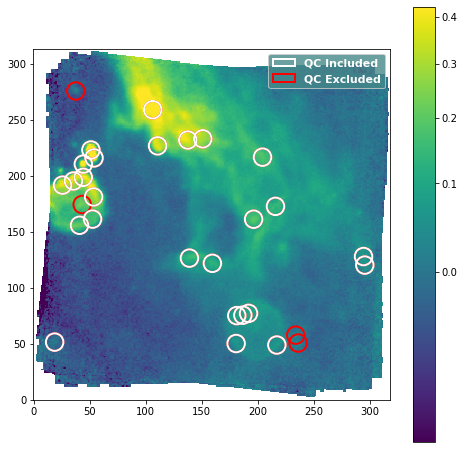

In [89]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

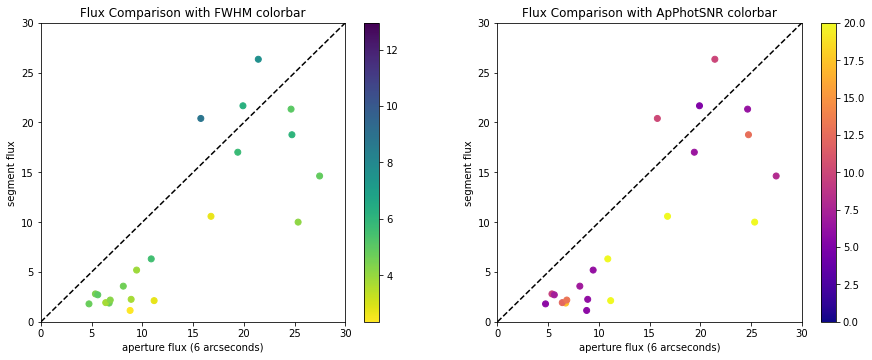

In [90]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

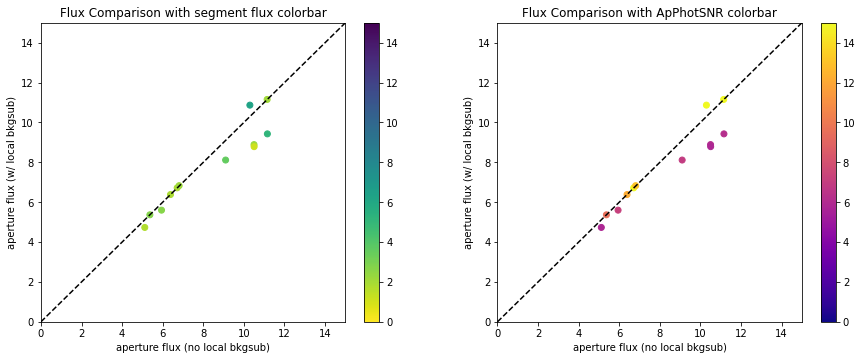

In [91]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [92]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)